# Prediction of expression modulation targets with FSEOF

Algorithms like Optgene can predict gene knockout targets, but another possibility for optimizing hemoglobin production is up- or downregulation of genes. A function for this is the Flux Scanning based on Enforced Objective Flux (FSEOF) from the Computer Aided Metabolic Engineering & Optimization (CAMEO) package (Cardoso et al. 2018). FSEOF searches for target genes for up- or down-regulation by first enforcing the flux of a desired reaction under the objective of maximizing biomass production (Choi et al 2010). The function then indentifies the metabolic fluxes that increased or decreased when the desired reaction was forced to increase (Choi et al 2010). 

### Running FSEOF and getting all regulation targets

Model and package imports:

In [65]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
import numpy as np
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
import matplotlib.pyplot as plt

In [2]:
model = read_sbml_model('model_yeast8_rhb.xml')

First, the FSEOF analysis is defined and run. As specified in fseof.run, the target for optimization is here the "EX_rHb" reaction, which is the exchange reaction for hemoglobin. By default the flux of the target reaction is maximized to 90% of its theoretical maximum. Furthermore, the primary objective in the optimization is the model.objective by default (here, biomass).

In [3]:
fseof = FSEOF(model)

In [4]:
result = fseof.run(target=model.reactions.EX_rHb)

The results are saved in a dataframe:

In [5]:
df = result.data_frame

Below are shown the top and bottom hits of the FSEOF analysis. Each row is a different reaction that changed flux with the forced flux increase of hemoglobin exchange, and which should therefore be up- or down-regulated. Each column shows the fluxes observed for the given reaction, when EX_rHb is increased in steps until the specified 90% of theoretical maximum (column 10). The result shows that are there **194** targets. 

In [6]:
df

,1,2,3,4,5,6,7,8,9,10
PRMICI,0.011281,0.016185,0.021088,0.025992,0.030876,0.035750,0.040625,0.045500,0.050374,0.055234
AATA,0.031468,0.035403,0.039339,0.043274,0.047127,0.050938,0.054749,0.058560,0.062371,0.066119
DDPAm,0.039051,0.042897,0.046743,0.050590,0.054330,0.058017,0.061704,0.065392,0.069079,0.072684
IPPMIb,-0.036383,-0.044254,-0.052124,-0.059994,-0.067778,-0.075519,-0.083260,-0.091002,-0.098743,-0.106418
IPPS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106418
...,...,...,...,...,...,...,...,...,...,...
ACONTm,0.127718,0.138886,0.150053,0.161221,0.149069,0.155116,0.161163,0.167210,0.173257,0.179034
PYRTRAINPROSYM,-0.339728,-0.427939,-0.516150,-0.604361,-0.691815,-0.778889,-0.865963,-0.953037,-1.040111,-1.126602
SHSL2,0.001456,0.002261,0.003066,0.003871,0.004674,0.005476,0.006278,0.007080,0.007882,0.008683
rHb,0.000144,0.000287,0.000431,0.000574,0.000718,0.000861,0.001005,0.001148,0.001292,0.001436


### Identifying reactions with the largest change in flux 

To get a better overview of the results, two columns are added to the dataframe: Change and Percent Change. The Change describes the change (positive or negative) in flux from the first calculated flux to the last (at 90% of theoretical max for desired product). The Percent Change describes the change in percentage relative to the beginning value, as calculated by:

$\frac{flux_{end} - flux_{start}}{flux_{start}} * 100$

If the flux of a reaction is zero in the beginning, the Percent Change is defined as NaN.

In [7]:
change = []
for i in range(len(df)):
    change.append(df.iloc[i,9]-df.iloc[i,0])
    
df['Change']=change

In [8]:
percent_change = []
for i in range(len(df)):
    if df.iloc[i,0] != 0:
        percent_change.append(((df.iloc[i,9]-df.iloc[i,0])/df.iloc[i,0])*100)
    else:
        percent_change.append(np.nan)

df['Percent_change']=percent_change

The reactions can then be sorted based on Percent Change to see the reactions with the highest relative change and thereby most interesting targets. Below are shown the top 20 targets with the highest expression modulation:

In [9]:
df_sorted = df.reindex(df.Percent_change.abs().sort_values(ascending=False).index) 
df_sorted.head(10)

,1,2,3,4,5,6,7,8,9,10,Change,Percent_change
GLYSTASYN,0.027650,0.025033,0.022416,0.019799,0.096385,0.227567,0.358748,0.489930,0.621111,0.647145,0.619495,2240.488246
PPPG9tm,0.000574,0.001148,0.001723,0.002297,0.002871,0.003445,0.004019,0.004594,0.005168,0.005742,0.005168,900.348432
FE2utm,0.000574,0.001148,0.001723,0.002297,0.002871,0.003445,0.004019,0.004594,0.005168,0.005742,0.005168,900.348432
UPP3S,0.000574,0.001148,0.001723,0.002297,0.002871,0.003445,0.004019,0.004594,0.005168,0.005742,0.005168,900.348432
UPPDC1,0.000574,0.001148,0.001723,0.002297,0.002871,0.003445,0.004019,0.004594,0.005168,0.005742,0.005168,900.348432
PPPGOm,0.000287,0.000574,0.000861,0.001148,0.001436,0.001723,0.002010,0.002297,0.002584,0.002871,0.002584,900.348432
HMBS,0.000574,0.001148,0.001723,0.002297,0.002871,0.003445,0.004019,0.004594,0.005168,0.005742,0.005168,900.348432
FCLTm,0.000574,0.001148,0.001723,0.002297,0.002871,0.003445,0.004019,0.004594,0.005168,0.005742,0.005168,900.348432
CPPPGO,0.000574,0.001148,0.001723,0.002297,0.002871,0.003445,0.004019,0.004594,0.005168,0.005742,0.005168,900.348432
EX_rHb,0.000144,0.000287,0.000431,0.000574,0.000718,0.000861,0.001005,0.001148,0.001292,0.001436,0.001292,900.000000


To get more insight to the expression modulation targets, we can count the number of up- and down-regulations targets. Note that a negative flux, which becomes more negative is an upregulation (the minus is due to the definition of the reaction direction). On the other hand, when a negative flux which becomes more positive, it is a downregulation.

In [33]:
upreg_counter = 0
downreg_counter = 0
for i in range(0,195):
    if df_sorted.iloc[i,11] > 0:
        upreg_counter = upreg_counter + 1
    elif df_sorted.iloc[i,11] < 0:
        downreg_counter = downreg_counter + 1
    elif np.isnan(df_sorted.iloc[i,11]):         # the reactions which had 0 flux in the beginning is counted by the "Change" column instead
        if df_sorted.iloc[i,10] > 0:
            upreg_counter = upreg_counter + 1
        elif df_sorted.iloc[i,10] < 0:
            downreg_counter = downreg_counter + 1
            
print("There are",upreg_counter,"up-regulation targets and",downreg_counter,"down-regulation tagets.")

There are 151 up-regulation targets and 44 down-regulation tagets.


We can visualize their degree of up- or down-regulation in a plot:

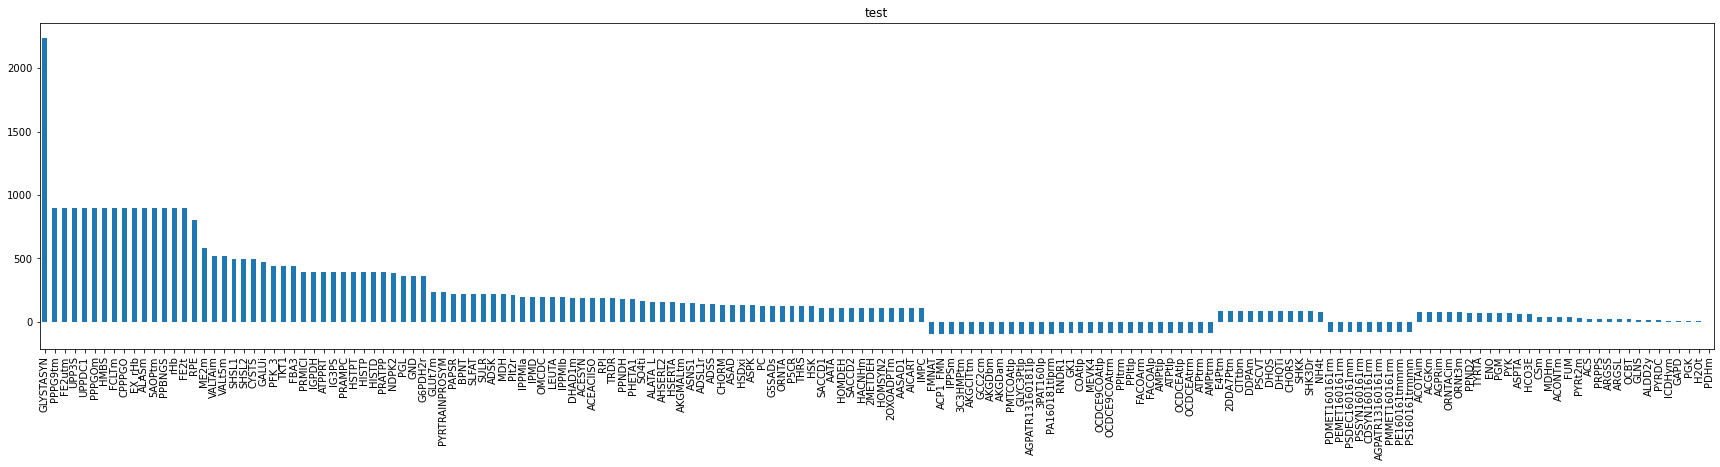

In [67]:
plotdata = df_sorted.iloc[0:168,11]
plotdata.plot(kind='bar',title='test')
plt.rcParams["figure.figsize"] = [30, 6]

### Investigation of top 10 targets with visualization

The reaction name for the top 10 reactions with the highest relative change is given below:

In [11]:
for i in range(10):
    print(model.reactions.get_by_id(df_sorted.index.values[i]).id, model.reactions.get_by_id(df_sorted.index.values[i]).name)

GLYSTASYN glycogen (starch) synthase
PPPG9tm protoporphyrinogen IX transport
FE2utm iron (II) transport
UPP3S uroporphyrinogen-III synthase
UPPDC1 uroporphyrinogen decarboxylase (uroporphyrinogen III)
PPPGOm protoporphyrinogen oxidase
HMBS hydroxymethylbilane synthase
FCLTm ferrochelatase
CPPPGO coproporphyrinogen oxidase (O2 required)
EX_rHb 


From the names above, it can be found that 9 out of 10 targets in top 10 are closely related to the hemoglobin synthesis. 7 of the reactions are found in the heme synthesis that is used to produce hemoglobin, one reaction (FE2utm) transports Iron(II) into the mitochondrion and another exports hemoglobin from the cell to the medium (EX_rHb). Addtionally, it can be seen from Percent Change columns that all targets in top 10 have a positive percent change and therefore are *up*-regulated.

To get a better overview of the upregulated targets involved in the hemoglobin synthesis, they can be visualized with Escher (King et al. 2015). 

In [ ]:
import escher

To visualize the top 10 upregulated pathways, a dictionary is created which contains their reaction id as well as their flux when the target reaction is at 90% of max productivity (column 10).

In [30]:
Reg_fluxes = dict(zip(df_sorted.index.values[0:10], df_sorted.iloc[0:10,10]))

In [37]:
escher.Builder(model = model,
    map_json='Yeast8_hemoglobin_synthesis2.json',
               reaction_data=Reg_fluxes)

Builder(reaction_data={'GLYSTASYN': 0.619495, 'PPPG9tm': 0.005168, 'FE2utm': 0.005168, 'UPP3S': 0.005168, 'UPP…

In [68]:
with model:
    for i in range(0,10):
        model.reactions.get_by_id(df_sorted.index.values[i]).bounds = df_sorted.iloc[i,10], df_sorted.iloc[i,10]
    model.optimize()
    print('Parameters for strain with 10 upregulated targets:')
    print("Rate of heme production:", model.reactions.FCLTm.flux)
    print("Rate of hemoglobin production:", model.reactions.EX_rHb.flux)
    print("Growth rate:", model.reactions.GROWTH.flux)

    #niko says change upper and lower bound to the things we got in the matrix -> simulated up-regulated

Parameters for strain with 10 upregulated targets:
Rate of heme production: 0.005167816788657618
Rate of hemoglobin production: 0.00129195
Growth rate: 0.016788657660049392


C:\Users\carol\Anaconda\lib\site-packages\cobra\util\solver.py:554: UserWarning:

Solver status is 'infeasible'.



In [19]:
with model:
    for i in range(0,190):
        model.reactions.get_by_id(df_sorted.index.values[i]).bounds = df_sorted.iloc[i,10], df_sorted.iloc[i,10]
    model.optimize()
    print('Parameters for strain with 10 upregulated targets:')
    print("Rate of heme production:", model.reactions.FCLTm.flux)
    print("Rate of hemoglobin production:", model.reactions.EX_rHb.flux)
    print("Growth rate:", model.reactions.GROWTH.flux)

    #niko says change upper and lower bound to the things we got in the matrix -> simulated up-regulated

Parameters for strain with 10 upregulated targets:
Rate of heme production: 0.0051678
Rate of hemoglobin production: 0.00129195
Growth rate: 0.0


### Sources:

Cardoso, J. G. R., Jensen, K., Lieven, C., Hansen, A. S. L., Galkina, S., Beber, M., Özdemir, E., Herrgård, M. J., Redestig, H., & Sonnenschein, N. (2018). Cameo: A Python Library for Computer Aided Metabolic Engineering and Optimization of Cell Factories. ACS Synthetic Biology, 7(4), 1163–1166. https://doi.org/10.1021/acssynbio.7b00423  

Choi, H. S., Lee, S. Y., Kim, T. Y., & Woo, H. M. (2010). In silico identification of gene amplification targets for improvement of lycopene production. Applied and Environmental Microbiology, 76(10), 3097–3105. https://doi.org/10.1128/AEM.00115-10

King, Z. A., Dräger, A., Ebrahim, A., Sonnenschein, N., Lewis, N. E., & Palsson, B. O. (2015). Escher: A Web Application for Building, Sharing, and Embedding Data-Rich Visualizations of Biological Pathways. PLoS Computational Biology, 11(8), 1–13. https://doi.org/10.1371/journal.pcbi.1004321